In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
# Import Normalizer
from sklearn.preprocessing import Normalizer
from scipy.cluster.hierarchy import fcluster
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import seaborn as sns
from sklearn import preprocessing
import matplotlib as mpl
import matplotlib.patches as patches
from matplotlib.patches import Circle, Wedge, Polygon, Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from numpy.linalg import eig
from numpy import array
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

Loading well log data and considering depth >7000ft.

In [2]:
las_1= pd.read_csv('WellA_edit.csv', header=0) #
las_old = las_1[las_1['DEPT']>7000]   
las_old.columns = ['Depth', 'Gamma_ray', 'Shale_volume', 'Restivity', 'Delta T', 'Vp', 'Vs',\
              'density', 'density_calculated', 'Neutron Porosity', 'Density_porosity', 'Poissons_ratio','classification']
#'classification'

In [3]:
las_old.Vp=(las_old.Vp)*0.0003048
las_old.Vs=(las_old.Vs)*0.0003048# ft/s to km/s 0.0003048
las_old.head()

/home/titli/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,Depth,Gamma_ray,Shale_volume,Restivity,Delta T,Vp,Vs,density,density_calculated,Neutron Porosity,Density_porosity,Poissons_ratio,classification
4073,7001,72.152,0.6597,0.65,112.78,2.702607,1.248314,2.2266,2.2266,-999.25,0.2256,0.3644,4
4074,7002,70.402,0.6327,0.62,113.28,2.690678,1.241723,2.2207,2.2207,-999.25,0.2307,0.3647,1
4075,7003,73.652,0.6681,0.60,112.28,2.714642,1.256869,2.2302,2.2302,-999.25,0.2229,0.3636,4
4076,7004,69.965,0.6176,0.61,111.78,2.726785,1.271524,2.2266,2.2266,-999.25,0.2277,0.3611,4
4077,7005,71.840,0.6358,0.61,113.28,2.690678,1.241414,2.2210,2.2210,-999.25,0.2303,0.3648,1


Using 6 parameters for unsupervised classification.

In [4]:
las_old.fillna(value=0, inplace=True)
feature_columns =  'Gamma_ray density Vp Vs Density_porosity Poissons_ratio'.split()

/home/titli/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3035: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


Plot well log dataset

In [5]:
default_color='C0'
def mpwell(tracks, title=None, mindepth=None, maxdepth=None, tagged_depths=None):
    """Create a well log using matplotlib.
       tracks: list of tracks. Each track is a dictionary with a 'traces'
       key (required), and possibly keys that describe the scale (log or linear)
       and appearance of the track. The 'traces' key points to a list of traces.
       Each trace is a dictionary containing a 'data' key that points to a Pandas
       DataFrame that contains the data to be plotted. The DataFrame must have
       a column named 'depth' that contains the depth in the desired units, and 
       also a column named the same as value of the 'curve' key in the trace. The
       trace dictionary may also have a 'label' key that provides the log mnemonic 
       for the trace, and additional keys that describe the appearance of the trace.
       title: Display title for the log.
       mindepth: minimum depth to be plotted. Optional. Determined from the first trace
       of the first track, if not specified.
       maxdepth: maximum depth to be plotted. Optional. Determined from the first trace
       of the first track, if not specified.
       tagged_depths: List of depths which should be marked on the logs with a horizontal
       line.
    """
    sns.set(rc={"figure.figsize": (14, 16)})
    sns.set_style("white")
    majorLocator = MultipleLocator(50) #50
    majorFormatter = FormatStrFormatter('%d')
    minorLocator = MultipleLocator(10) #10
    f, axs = plt.subplots(nrows=1, ncols=len(tracks), figsize=(14, 16))
    #if title:
       # f.suptitle(title, fontsize=22)
    # reserve space at the top and between subplots
    f.subplots_adjust(top=0.99,wspace=0.25)
    first_trace_data = tracks[0]['traces'][0]['data']
    if mindepth is None:
        mindepth = min(first_trace_data['depth'])
    if maxdepth is None:
        maxdepth = max(first_trace_data['depth'])
    # set up each track
    for ax in axs:
        ax.set_ylim(mindepth,maxdepth)
        #ax.invert_yaxis()
        ax.get_xaxis().set_visible(True)
        ax.get_yaxis().set_visible(True)
        ax.yaxis.set_minor_locator(minorLocator)
        ax.yaxis.set_major_locator(majorLocator)
        ax.yaxis.grid(b=True, which='major', color='k', linestyle='-')
        ax.yaxis.grid(b=True, which='minor', color='k', linestyle='-', alpha=0.5)
        ax.minorticks_on()
        
    # plot each trace in each track
    for num_track, track in enumerate(tracks):
        for i, trace in enumerate(track['traces']):
            fill = track.get('fill', trace['fill'])
            color = track.get('color', trace['color'])
            label = trace.get('label', trace['curve'])
            ls = trace.get('ls', '-')
            marker = trace.get('marker', 'None')
            axi = axs[num_track].twiny()
            axi.set_ylim(mindepth, maxdepth)
            
            
            axi.set_xlabel(label, color=color, labelpad=5, fontsize=14)

            if (fill == 1):
                class_depth(axi,tagged_depths, label, color)
                axi.minorticks_off()
                axi.grid(False)
            else:
                axi.plot(tracks[num_track]['traces'][0]['data'], tagged_depths, ls=ls, marker=marker, color=color)
               # axi.set_xlim(*trace['range'])
                axi.spines['top'].set_position(('outward', 5+30*i))
                axi.spines['top'].set_color(color)
                axi.xaxis.set_ticks(trace['range'])
                axi.tick_params(axis='x', colors=color, length=0)
                #plt.grid(b=True, which='minor', color='r', linestyle='-', alpha=0.2)
                extent= (trace['range'][1] - trace['range'][0])/5
                extent1= extent/3
                majorLocator1 = MultipleLocator(extent)
                minorLocator1 = MultipleLocator(extent1)
                axi.xaxis.set_major_locator(majorLocator1)
                axi.xaxis.set_minor_locator(minorLocator1)
                axi.xaxis.grid(b=True, which='major', color='k', linestyle='-')
                axi.xaxis.grid(b=True, which='minor', color='r', linestyle='-.', alpha=0.2)
                x_pos=[trace['range'][0],trace['range'][0]+extent, trace['range'][0]+2*extent,\
                       trace['range'][0]+3*extent,trace['range'][0]+4*extent,trace['range'][1]]
                x_pos_label=[trace['range'][0], '','','','', trace['range'][1]]
                axi.set_xticks(x_pos)
                axi.set_xticklabels(x_pos_label, rotation = 0)
                axi.invert_yaxis()
                
                
            if 'xref' in trace:
                axi.axvline(trace['xref'], color='k', linestyle='--')
           
            
            if num_track>0:
                axi.set_yticklabels([])
                #axi.set_yticklabels()
            else:
                # Turn off the "offset" in the y-axis labeling
                y_formatter = mpl.ticker.ScalarFormatter(useOffset=False)
                axi.yaxis.set_major_formatter(y_formatter)
                
        axs[0].set_ylabel('Depth (ft)',fontsize=16)
    return f

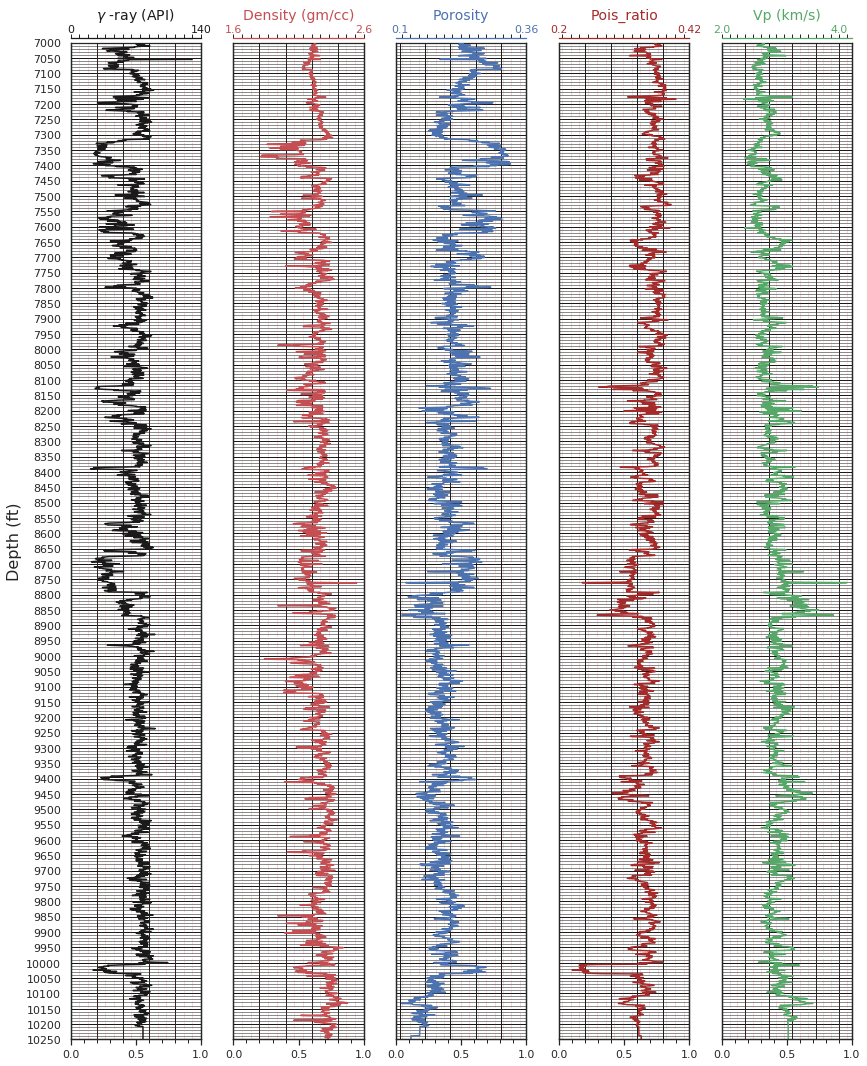

In [6]:
trace11 = {'data': las_old['Gamma_ray'], 'curve': '$\gamma$ -ray (API)', 'color': 'k', 'fill':0,'range': (0, 140)}
track1 = {'traces': [trace11]}
trace21 = {'data': las_old['density'], 'curve': 'Density (gm/cc)', 'color': 'r','fill':0,'range': (1.6, 2.6)}
track2 = {'traces': [trace21]}
trace31 = {'data': las_old['Density_porosity'], 'curve': 'Porosity', 'color': 'b', 'fill':0,'range': (0.1, 0.36)}
track3 = {'traces': [trace31]}
trace41 = {'data': las_old['Poissons_ratio'], 'curve': 'Pois_ratio', 'color':'brown' ,'fill':0,'range': (0.2, 0.42)}
track4 = {'traces': [trace41]}
trace51 = {'data': las_old['Vp'], 'curve': 'Vp (km/s)', 'color':'g','fill':0,'range': (2.0, 4.0)}
track5 = {'traces': [trace51]}
tracks = [track1, track2, track3, track4, track5]
xrd_depths = las_old['Depth']
log = mpwell(tracks, 'My well', min(xrd_depths), max(xrd_depths), las_old['Depth'].values ) #

Using cross plots to get an overview the probable type of rocks present.

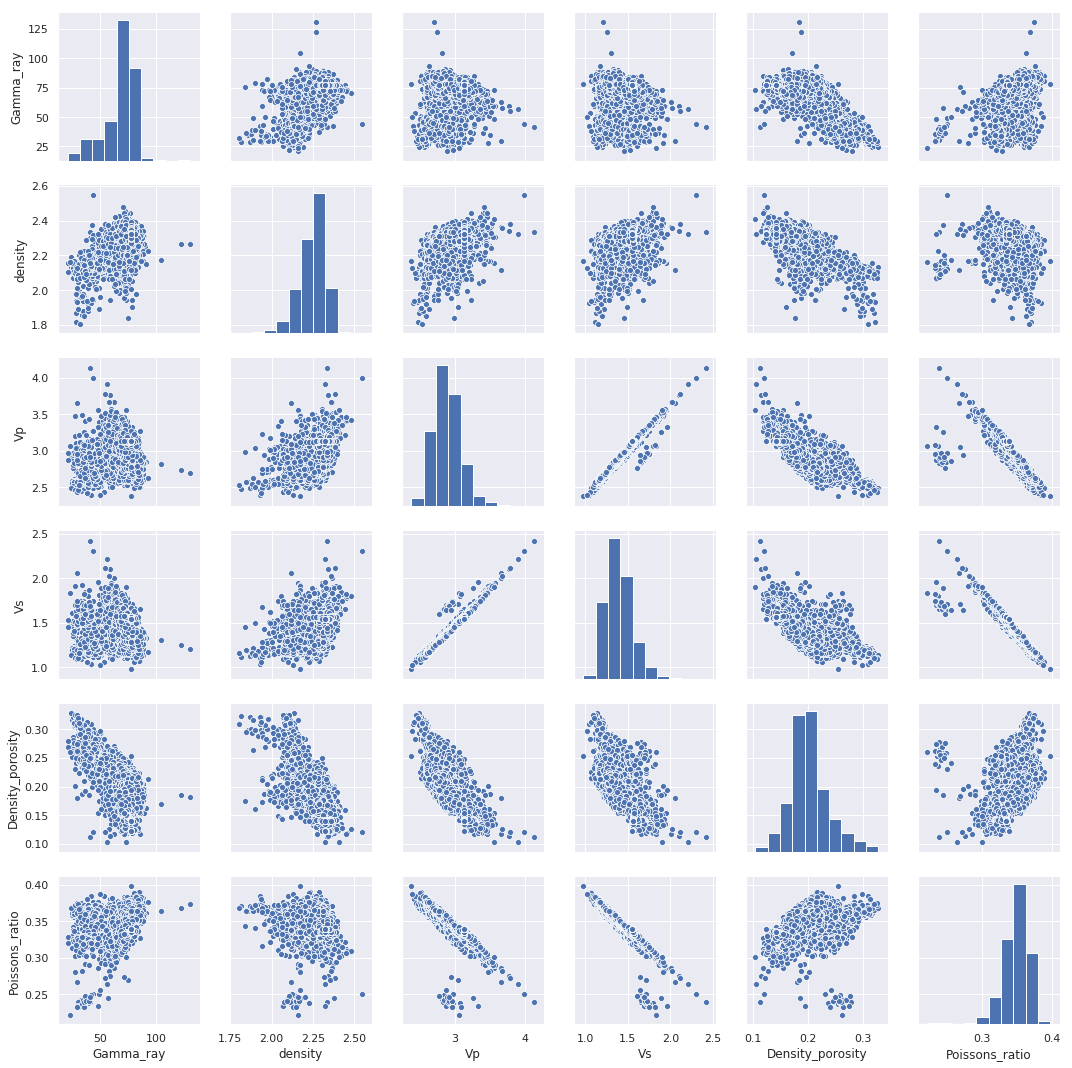

In [7]:
inline_rc = dict(mpl.rcParams)

import seaborn as sns
sns.set()
sns.pairplot(las_old[feature_columns])

#switch back to default matplotlib plot style
mpl.rcParams.update(inline_rc)

In [34]:
#f,ax = plt.subplots(figsize=(5, 20))
def class_depth (ax, depth, label, color):

    patches = []
    for i in range(len(las)):
        poly=Rectangle((0,depth[i]), 4, 1)
    #poly=Rectangle([(0, depth[i]), (5, depth[i]), (0 , depth[i]+1), (5 , depth[i]+1) ], True)
        patches.append(poly)
    cmap = plt.get_cmap(rvb)
    p = PatchCollection(patches, match_original=False, cmap=cmap, alpha=0.7)
    colors = np.array(las.classification)
    print(np.unique(colors))
    #p.set_array(np.array(colors))
    p.set_array(np.array(colors))
    ax.add_collection(p)
    ax.invert_yaxis()
    ax.set_xlabel(label, color=color, labelpad=5, fontsize=14)
    x_pos_label=['', '','','']
    ax.set_xticklabels(x_pos_label, rotation = 0)
    ax.get_xaxis().set_visible(True)
    #ax.set_xlim([0,4])

PCA method to reduce dimensionality although not very useful when using only 6 parameters. Normalize the parameters because the units are different.

In [38]:
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(las_old[feature_columns].values)
X = pd.DataFrame(x_scaled)

In [39]:
V = np.cov(C.T)
#print(V)
values, vectors = eig(V)
#sort the top 2 eigen values
sorted_index = values.argsort()[::-1] 
values = values[sorted_index]
vectors = vectors[:,sorted_index]
vectors = vectors[:,:3]
# project data
reduced_data = vectors.T.dot(C.T)
reduced_data = reduced_data.T
print((reduced_data.shape))

(3250, 3)


In [40]:
M = np.mean(X)
C = X - M

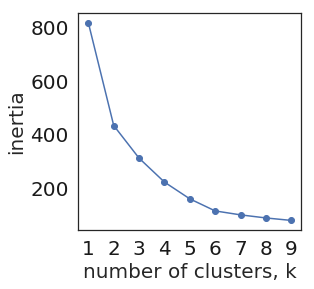

In [41]:
## How to choose number of clusters
ks = range(1, 10)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model=KMeans(n_clusters=k , random_state=3425)
    
    # Fit model to samples
    model.fit(reduced_data)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
#namebank =[0,0.61, 0.68, 0.70, 0.73, 0.80, 0.85, 0.81,0.70]
sns.set(rc={"figure.figsize": (4, 4)})
sns.set_style("white")
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k', size=20)
plt.ylabel('inertia', size=20)
plt.xticks(ks)
plt.tick_params(direction='out', length=6, width=2, colors='k')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.grid(True, which='major', axis='y', color="white", linewidth=1, zorder=1)
plt.show()
############################


In [22]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9]

for n_clusters in range_n_clusters:
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(reduced_data)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(reduced_data, cluster_labels)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)


For n_clusters = 2 The average silhouette_score is : 0.31383214662749986
For n_clusters = 3 The average silhouette_score is : 0.3676619427633731
For n_clusters = 4 The average silhouette_score is : 0.3825403444477597
For n_clusters = 5 The average silhouette_score is : 0.32861257280254863
For n_clusters = 6 The average silhouette_score is : 0.2957774345983137
For n_clusters = 7 The average silhouette_score is : 0.30411231802565103
For n_clusters = 8 The average silhouette_score is : 0.29356825001545866
For n_clusters = 9 The average silhouette_score is : 0.27774386955788793


Using cluster 4 and 5 to calculate the labels.

In [42]:
# Create scaler: scaler
scaler = StandardScaler()
# Create KMeans instance: kmeans
kmeans = KMeans(n_clusters=4)
# Create pipeline: pipeline
pipeline = make_pipeline(scaler, kmeans)
pipeline.fit(reduced_data)
labels_1 = pipeline.predict(reduced_data)+1
np.unique(labels_1)

array([1, 2, 3, 4], dtype=int32)

In [43]:
# Create scaler: scaler
scaler = StandardScaler()
# Create KMeans instance: kmeans
kmeans = KMeans(n_clusters=5)
# Create pipeline: pipeline
pipeline = make_pipeline(scaler, kmeans)
pipeline.fit(reduced_data)
labels_2 = pipeline.predict(reduced_data)+1
np.unique(labels_2)

array([1, 2, 3, 4, 5], dtype=int32)

In [44]:
las_old['cluster4']= labels_1
las_old['cluster5']= labels_2

/home/titli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/titli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [45]:
D_colors = {1:'#F4D03F', 2:'#F5B041', 3:'#DC7633', 4:'#6E2C00', 5:'#1B4F72', 6:'#2E86C1'}
color_map = [color for color in D_colors.values()]

Text(0.5,1,'Cluster 5')

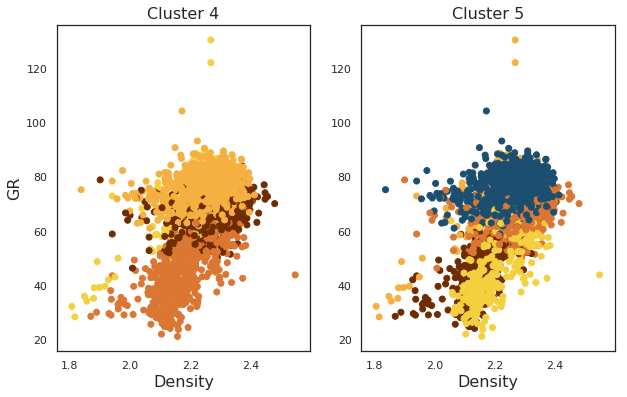

In [47]:
sns.set(rc={"figure.figsize": (10, 6)})
sns.set_style("white")
f, axes = plt.subplots(1, 2)
axes[0].scatter(las_old['density'], las_old['Gamma_ray'],
            c=las_old['cluster4'].apply(lambda x: D_colors[x]))
axes[0].set_xlabel('Density', Fontsize=16)
axes[0].set_ylabel('GR', Fontsize=16)
axes[0].set_title('Cluster 4', Fontsize=16)
axes[1].scatter(las_old['density'], las_old['Gamma_ray'], \
            c=las_old['cluster5'].apply(lambda x: D_colors[x]))
axes[1].set_xlabel('Density', Fontsize=16)
axes[1].set_title('Cluster 5', Fontsize=16)

In [48]:
def make_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['cluster5'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(14, 12))
    ax[0].plot(logs.Gamma_ray, logs.Depth, '-g')
    ax[1].plot(logs.density, logs.Depth, '-')
    ax[2].plot(logs.Density_porosity, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.Poissons_ratio, logs.Depth, '-', color='r')
    ax[4].plot(logs.Vp, logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
      
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.Gamma_ray.min(),logs.Gamma_ray.max())
    ax[1].set_xlabel("Density")
    ax[1].set_xlim(logs.density.min(),logs.density.max())
    ax[2].set_xlabel("Density_porosity")
    ax[2].set_xlim(logs.Density_porosity.min(),logs.Density_porosity.max())
    ax[3].set_xlabel("Poissons_ratio")
    ax[3].set_xlim(logs.Poissons_ratio.min(),logs.Poissons_ratio.max())
    ax[4].set_xlabel("Vp")
    ax[4].set_xlim(logs.Vp.min(),logs.Vp.max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well A', fontsize=14,y=0.94)


In [49]:
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

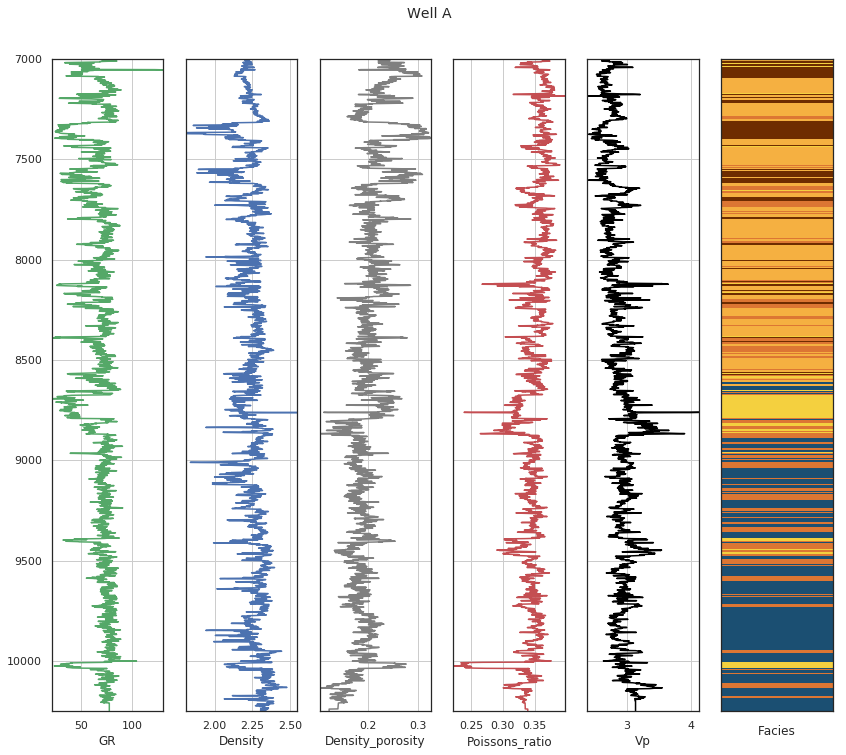

In [50]:
feature_columns =  'Depth Gamma_ray density Vp Vs Density_porosity Poissons_ratio cluster5'.split()
make_facies_log_plot(las_old[feature_columns], facies_colors)